# Cleaning the code - Assingment class on 30March23

In [16]:
#import libraries
import os
import pandas as pd
import numpy as np
import re
from scipy.stats import gmean
from scipy import stats
import matplotlib.pyplot as plt

In [17]:
# Sets the path to the parent directory of RR classes
os.chdir("C:\\Users\\Afat\\Documents\\UW - MASTER\\1Y2S\\RR\\RRcourse2023\\6. Coding and documentation")

In [18]:
# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.

task_data = pd.read_csv("Data\\onet_tasks.csv")

In [19]:
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)

# Read the Excel file
df = pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name=None)

# Calculate worker totals for each country
countries = ["Belgium", "Spain", "Poland"]
totals = {}
for country in countries:
    total = sum([df[f"ISCO{i}"][country] for i in range(1, 10)])
    totals[country] = total

In [20]:
# Add ISCO column to each sheet and merge
dfs = []
for i, sheet_name in enumerate(df.keys()):
    sheet_df = df[sheet_name]
    sheet_df["ISCO"] = i+1
    dfs.append(sheet_df)
all_data = pd.concat(dfs, ignore_index=True)

# Calculate totals for each country
countries = ["Belgium", "Spain", "Poland"]
totals = {}
for country in countries:
    total = all_data[all_data[country].notnull()].groupby("ISCO")[country].sum()
    totals[country] = total

# Calculate shares for each country
for country in countries:
    all_data[f"share_{country}"] = all_data[country] / totals[country][all_data["ISCO"]].reset_index(drop=True)



In [21]:
# Now let's look at the task data. We want the first digit of the ISCO variable only

task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

# And we'll calculate the mean task values at a 1-digit level 
# (more on what these tasks are below)
aggdata = task_data.groupby(["isco08_1dig"]).mean().drop(columns=["isco08"])


# We'll be interested in tracking the intensity of Non-routine cognitive analytical tasks
# Using a framework reminiscent of the work by David Autor.

#These are the ones we're interested in:
# Non-routine cognitive analytical
# 4.A.2.a.4 Analyzing Data or Information
# 4.A.2.b.2 Thinking Creatively
# 4.A.4.a.1 Interpreting the Meaning of Information for Others

#Let's combine the data.
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')
# Traditionally, the first step is to standardize the task values using weights 
# defined by share of occupations in the labor force. This should be done separately
# for each country. Standardization -> getting the mean to 0 and std. dev. to 1.

# Let's do this for each of the variables that interest us:
countries = ["Belgium", "Poland", "Spain"]

for task_item in ["t_4A2a4", "t_4A2b2", "t_4A4a1"]:
    for country in countries:
        # Standardize the task value for this country and task item
        task_colname = f"{country}_std_{task_item}"
        weights_colname = f"share_{country}"
        
        temp_mean = np.average(combined[task_item], weights=combined[weights_colname])
        temp_sd = np.sqrt(np.average((combined[task_item] - temp_mean)**2, weights=combined[weights_colname]))
        combined[task_colname] = (combined[task_item] - temp_mean) / temp_sd


In [22]:

task_items = [["t_4A2a4", "std_Belgium_t_4A2a4", "std_Poland_t_4A2a4", "std_Spain_t_4A2a4"],
              ["t_4A2b2", "std_Belgium_t_4A2b2", "std_Poland_t_4A2b2", "std_Spain_t_4A2b2"],
              ["t_4A4a1", "std_Belgium_t_4A4a1", "std_Poland_t_4A4a1", "std_Spain_t_4A4a1"]]

for task in task_items:
    task_name, std_belgium_name, std_poland_name, std_spain_name = task
    for country in ["Belgium", "Poland", "Spain"]:
        temp_mean = np.average(combined[task_name], weights=combined[f"share_{country}"])
        temp_sd = np.sqrt(np.average((combined[task_name] - temp_mean)**2, weights=combined[f"share_{country}"]))
        combined[f"{eval('std_'+country.lower()+'_name')}"] = (combined[task_name] - temp_mean) / temp_sd


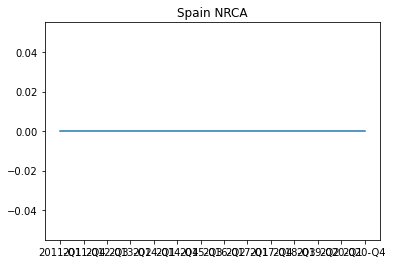

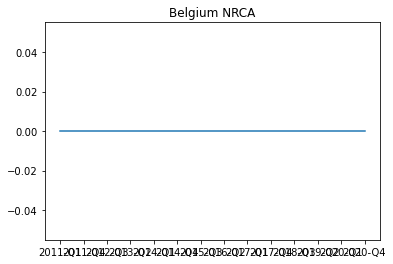

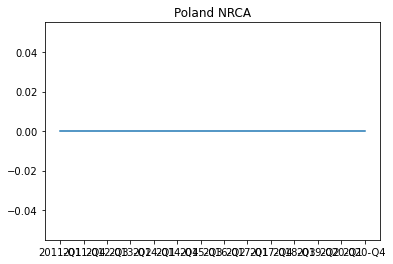

In [13]:
# Calculate the NRCA for each country
country_codes = ["Spain", "Belgium", "Poland"]
tasks = ["4A2a4", "4A2b2", "4A4a1"]

for country in country_codes:
    combined[f"{country}_NRCA"] = combined[[f"std_{country}_t_{task}" for task in tasks]].sum(axis=1)

# Standardise NRCA for each country
for country in country_codes:
    temp_mean = np.average(combined[f"{country}_NRCA"], weights=combined[f"share_{country}"])
    temp_sd = np.sqrt(np.average((combined[f"{country}_NRCA"] - temp_mean)**2, weights=combined[f"share_{country}"]))
    combined[f"std_{country}_NRCA"] = (combined[f"{country}_NRCA"] - temp_mean) / temp_sd

# Calculate country-level means
for country in country_codes:
    # Multiply by the share of workers
    combined[f"multip_{country}_NRCA"] = combined[f"std_{country}_NRCA"] * combined[f"share_{country}"]
    
    # Calculate the weighted sum
    agg_country = combined.groupby(["TIME"])[f"multip_{country}_NRCA"].sum().reset_index()
    
    # Plot the data
    plt.plot(agg_country["TIME"], agg_country[f"multip_{country}_NRCA"])
    plt.xticks(range(0, len(agg_country), 3), agg_country["TIME"][::3])
    plt.title(f"{country} NRCA")
    plt.show()
